# COURSE: A deep understanding of deep learning
## SECTION: ANNs
### LECTURE: CodeChallenge: Manipulate regression slopes
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [8]:
# import libraries
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# configure torch 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.get_num_threads())

6


## Create model functions

Write a Python funcitons that builds and trains the model, and output the final predictions and losses.

In [9]:
def buildModel() -> nn.Module:
    ANNreg = nn.Sequential(
        nn.Linear(1,1),
        nn.ReLU(),
        nn.Linear(1,1)
    )

    return ANNreg

def trainModel(model: nn.Module, x_train: torch.Tensor, y_train: torch.Tensor, epochs: int, lr: float) -> tuple[nn.Module, torch.Tensor]:
    lossfun = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    losses = torch.zeros(epochs)

    for epoch in range(epochs):
        # forward pass
        y_hat = model(x_train)

        # compute loss
        loss = lossfun(y_hat, y_train)
        losses[epoch] = loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    predictions = model(x_train)

    return predictions, losses



def buildAndTrainModel(x_train: torch.Tensor, y_train: torch.Tensor, epochs: int, lr: float) -> tuple[nn.Module, torch.Tensor]:
    model = buildModel()
    predictions, losses = trainModel(model, x_train, y_train, epochs, lr)

    return predictions, losses

## Create data functions

Write a function that creates de dadta and outputs `x`, `y`. `x` is the same as in the previous video. `y = m*x + randn/2`. `N=50`

In [10]:
def createDataX(n: int) -> torch.Tensor:
    return torch.randn(n, 1)

def createDataY(n: int, x: torch.Tensor, m:int) -> torch.Tensor:
    return m*x + torch.randn(n,1)/2

def createData(n: int, m: int) -> tuple[torch.Tensor, torch.Tensor]:
    x = createDataX(n)
    y = createDataY(n, x, m)

    return x, y

## Test once the functions

Just to see that everything works as expected.

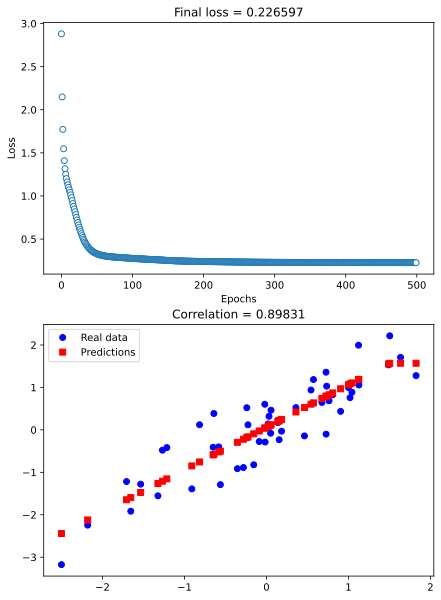

In [11]:
# Test once 

N = 50
M = 1
epochs = 500
lr = 0.05

x, y = createData(N, M)

predictions, losses = buildAndTrainModel(x, y, epochs, lr)
predictions = predictions.detach()

correlation_coef = np.corrcoef(y.T, predictions.T)[0,1]

fix,ax = plt.subplots(2,1,figsize=(7,10))

ax[0].plot(losses.detach(),'o',markerfacecolor='w',linewidth=.1) 
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Final loss = %g' %losses[-1])

ax[1].plot(x,y,'bo',label='Real data')
ax[1].plot(x,predictions,'rs',label='Predictions')
ax[1].set_title(f'Correlation = {correlation_coef:.5f}')
ax[1].legend()

plt.show()

## Generate a parametric experiment

In a parametric experiment, vary the slope from -2 to +2 in 21 steps. Repeat the entire experiment 50 times.

In [12]:
N = 50
lr = 0.05

experiment_epochs = 50
slopes = np.linspace(-2, 2, 21)
results = np.zeros((len(slopes),experiment_epochs,2))

for slopei in range(len(slopes)):
    for experiment in range(experiment_epochs):
        x, y = createData(N, slopes[slopei])
        predictions, losses = buildAndTrainModel(x, y, epochs, lr)
        predictions = predictions.detach()
        correlation_coef = np.corrcoef(y.T, predictions.T)[0,1]
        results[slopei, experiment, 0] = losses[-1]
        results[slopei, experiment, 1] = correlation_coef

results[np.isnan(results)] = 0 # detects which values are NaN and replaces them with 0


/home/jbermejo/repo/DeepUnderstandingOfDeepLearning/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/jbermejo/repo/DeepUnderstandingOfDeepLearning/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


/tmp/ipykernel_1726097/2694194930.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend()


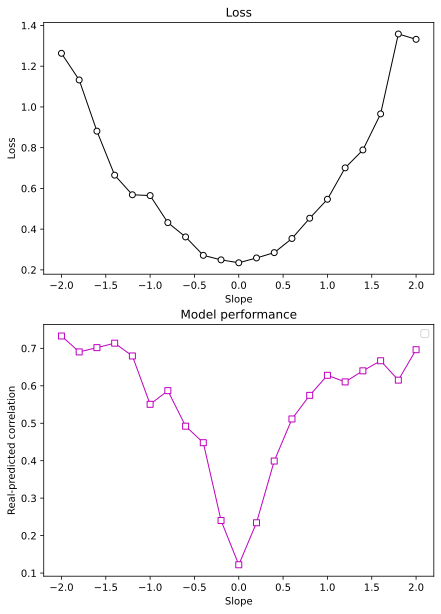

In [14]:
fix,ax = plt.subplots(2,1,figsize=(7,10))

ax[0].plot(slopes, np.mean(results[:,:,0],axis=1),'ko-', markerfacecolor='w',linewidth=1) # axis 1 => mean of the experiments epochs
ax[0].set_xlabel('Slope')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss')

ax[1].plot(slopes,np.mean(results[:,:,1], axis=1),'ms-', markerfacecolor='w',linewidth=1)
ax[1].set_xlabel('Slope')
ax[1].set_ylabel('Real-predicted correlation')
ax[1].set_title('Model performance')
ax[1].legend()

plt.show()


## Explanation

We can see that the losses are smaller the closer it gets to slope 0. We can also see that the performance is awful the closer the slope get's to 0. It feels counterintuitive, but it's probably because the closer the slope gets to 0, the more noise it has to deal with.

The losses are bigger, because the bigger the slope, the bigger the variance. In a slope of 0, the `y` values will be close to 0. In a slope of 2, the `y` values will not be close to any values, as it will grow indefinitely. So the variance is bigger, but it's easier to predict the tendency of the data

This is why the performance is much better when we have a slope. The model can predict the tendency of the data, even if it's not perfect. x is less informative about y when the slope decreases. The model has less useful information about y
